In [1]:
import argparse
import os
import sys
import zipfile
import random
import torch
import yaml
from torch.utils.data import DataLoader
from train_model.dataset_utils import prepare_test_data_set
from urllib.request import FancyURLopener

import numpy as np
from os import listdir
from dataset_utils import text_processing
from train_model.helper import run_model, build_model
from IPython.display import Image, display, clear_output

# Get test images
# wget http://images.cocodataset.org/zips/test2015.zip, unzip and update path to image directory
im_dir = 'data/demo/images/'
# Get the models
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/pretrained_models/most_data_models.tar.gz and 
# move the best_model.pth from the uncompressed file to the folder best_model
# Get features
# mkdir data
# cd data
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/vqa2.0_glove.6B.300d.txt.npy
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/vocabulary_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/answers_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/imdb.tar.gz
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/rcnn_10_100.tar.gz
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/large_vocabulary_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/large_vqa2.0_glove.6B.300d.txt.npy
# tar -xf rcnn_10_100.tar.gz
# tar -xf imdb.tar.gz

config_file = 'config/demo/config.yaml'
# config_file = 'best_model/config.yaml'
model_file = 'best_model/demo_model.pth'


demo_prereqs = {'best_model':
                   {'url':'https://s3-us-west-1.amazonaws.com/vqa-suite/data/demo_model.pth',
                    'rel_path':'./best_model/' },
                'large_vocab': 
                   {'url': 'https://s3-us-west-1.amazonaws.com/vqa-suite/data/large_vocabulary_vqa.txt',
                    'rel_path':'./data/'},
                'large_vocab_glove': 
                   {'url':'https://s3-us-west-1.amazonaws.com/vqa-suite/data/large_vqa2.0_glove.6B.300d.txt.npy',
                    'rel_path':'./data/'},
                'answers':
                   {'url': 'https://s3-us-west-1.amazonaws.com/vqa-suite/data/answers_vqa.txt',
                    'rel_path':'./data/'}}

def maybe_download(file_id):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\rDownloading %s %.1f%%' % (file_url,
          float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    
    rel_path = demo_prereqs[file_id]['rel_path']
    file_url = demo_prereqs[file_id]['url']
    destination = os.path.join(rel_path, file_url.split('/')[-1])
    
    if os.path.isfile(destination):
        print('File ID {} already exists at {}'.format(file_id, destination))
    else:
        if not os.path.exists(rel_path):
            os.makedirs(rel_path)
        urlretrieve = FancyURLopener().retrieve
        urlretrieve(file_url, destination, _progress)
        
def get_image():
    im_files = [f for f in os.listdir(im_dir)]
    im_file = random.choice(im_files)
    im_path = os.path.join(im_dir, im_file)
    print(im_path)
    clear_output()
    display(Image(filename=im_path))
    return im_file

def get_imdb(im_file, question_str):
    imdb = []
    imdb.append({'dataset_name': 'vqa', 'version': 1, 'has_answer': False, 'has_gt_layout': False})
    iminfo = {}
    iminfo['image_name'] = im_file.replace('.jpg', '')
    iminfo['img_id'] = int(iminfo['image_name'].split('_')[-1])
    iminfo['question_id'] = 0
    iminfo['feature_path'] = iminfo['image_name'] + '.npy'
    iminfo['question_str'] = question_str
    iminfo['question_tokens'] = text_processing.tokenize(iminfo['question_str'])
    imdb.append(iminfo)
    return imdb

def print_result(question_ids, soft_max_result, ans_dic):
    predicted_answers = np.argmax(soft_max_result, axis=1)
    for idx, pred_idx in enumerate(predicted_answers):
        question_id = question_ids[idx]
        pred_ans = ans_dic.idx2word(pred_idx)
        print(pred_ans)

def demo():
    
    for k in demo_prereqs.keys():
        maybe_download(k)
    
    with open(config_file, 'r') as f:
        config = yaml.load(f)

    data_set_test = prepare_test_data_set(**config['data'], **config['model'], verbose=True, test_mode=True)

    myModel = build_model(config, data_set_test)
    myModel.load_state_dict(torch.load(model_file)['state_dict'])

    print('VQA Demo')
    print('Say next to go to next image')
    print('Say stop to stop demo')
    im_file = get_image()
    while(True):
        print("What question would you like to ask?")
        question_str = input()
        if question_str.lower() == 'next':
            im_file = get_image()
            continue
        if question_str.lower() == 'stop':
            print('Bye')
            break
        data_set_test.datasets[0].imdb = get_imdb(im_file, question_str)
        data_reader_test = DataLoader(data_set_test, shuffle=False, batch_size=1)
        ans_dic = data_set_test.answer_dict

        question_ids, soft_max_result = run_model(myModel, data_reader_test, ans_dic.UNK_idx)
        print_result(question_ids, soft_max_result, ans_dic)

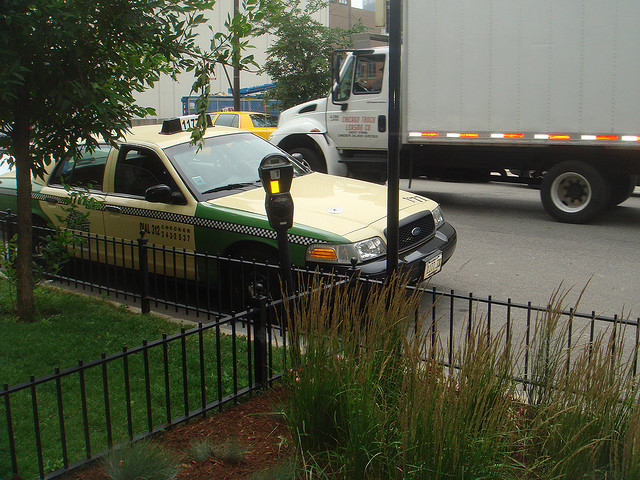

What question would you like to ask?
What is the color of the car?
yellow
What question would you like to ask?
What is the color of the truck?
white
What question would you like to ask?
How many vehicles in this image?
2
What question would you like to ask?


In [ ]:
demo()